In [26]:
"""
Starter code for the problem "Cart-pole swing-up with limited actuation".
Autonomous Systems Lab (ASL), Stanford University
"""

from functools import partial

import cvxpy as cp

# import jax
# import jax.numpy as jnp

import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm

In [27]:
# Constants

n = 6 # state dimension
m = 3 # control dimension
T = 50 # total time
dt = 0.1
mass = 1.0 # Mass
mean_motion = 1
rho = 20
max_iters = 100
eps = 0.5 # convergence tolerance
u_max = 1000 # control effort bound

P = 1e3*np.eye(n)                    # terminal state cost matrix
Q = np.diag([1, 1., 1, 1e-3, 1e-3, 1e-3])
# Q = np.diag([1e-1, 1e-1, 1e-1, 1e-2, 1e-2, 1e-2])  # state cost matrix
R = 1e-3*np.eye(m)  

s0 = np.array([50, 50, 50, 0, 0, 0]) # x, y, z, dx, dy, dz
s_goal = np.array([0, 0, 0, 0, 0, 0]) # location of target in space

In [28]:
# @partial(jax.jit, static_argnums=(0,))
# @partial(jax.vmap, in_axes=(None, 0, 0))

def state_space(T, n, m):
    # CWH equations for state space
    A = np.matrix([[4 - 3*np.cos(n*T), 0, 0, 1/n*np.sin(n*T), 2/n*(1-np.cos(n*T)), 0],
                  [6*(np.sin(n*T)-n*T), 1, 0, 2/n*(np.cos(n*T)-1), 1/n*(4*np.sin(n*T)-3*n*T), 0],
                  [0, 0, np.cos(n*T), 0, 0, 1/n*np.sin(n*T)],
                  [3*n*np.sin(n*T), 0, 0, np.cos(n*T), 2*np.sin(n*T), 0],
                  [6*n*(np.cos(n*T)-1), 0, 0, -2*np.sin(n*T), 4*np.cos(n*T)-3, 0],
                  [0, 0, -n*np.sin(n*T), 0, 0, np.cos(n*T)]])
    
    B = 1/m*np.matrix([[1/n**2*(1-np.cos(n*T)), 2/n**2*(n*T - np.sin(n*T)), 0],
                     [-2/n**2*(n*T - np.sin(n*T)), 4/n**2*(1-np.cos(n*T))-3/n*T, 0],
                     [0, 0, 1/n**2*(1-np.cos(n*T))],
                     [1/n*np.sin(n*T), -2/n*(np.cos(n*T)-1), 0],
                     [2/n*(np.cos(n*T)-1), 4/n*np.sin(n*T)-3/n*T, 0],
                     [0, 0, 1/n*np.sin(n*T)]])

    return (A, B)


In [29]:
def dynamics(N, mean_motion, mass):
    
    A = []
    B = []

    for k in range(N):
        # print("hi")
        Anew, Bnew = state_space(k, mean_motion, mass)
        A.append(Anew)
        B.append(Bnew)
        
    return (A, B)

In [30]:
def initial_guess(s0, s_goal, N, P, Q, R, A, B):
    n = Q.shape[0]
    m = R.shape[0]
    s_cvx = cp.Variable((N + 1, n))
    u_cvx = cp.Variable((N, m))


    # Construct the convex SCP sub-problem.
    objective = cp.quad_form((s_cvx[N] - s_goal), P) + cp.sum([(cp.quad_form((s_cvx[k] - s_goal), Q) + cp.quad_form(u_cvx[k], R)) for k in range(N)])
    
    constraints = [s_cvx[0] == s0]
    constraints += [(s_cvx[k + 1] == A[k]@s_cvx[k] + B[k]@u_cvx[k]) for k in range(N)]

    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve()
    
    s = s_cvx.value
    u = u_cvx.value
    return s, u

In [31]:
def scp_iteration(s0, s_goal, s_prev, u_prev, N, P, Q, R, u_max, rho, A, B):
    
    n = Q.shape[0]
    m = R.shape[0]
    s_cvx = cp.Variable((N + 1, n))
    u_cvx = cp.Variable((N, m))


    # Construct the convex SCP sub-problem.
    objective = cp.quad_form((s_cvx[N] - s_goal), P) + cp.sum([(cp.quad_form((s_cvx[k] - s_goal), Q) + cp.quad_form(u_cvx[k], R)) for k in range(N)])
    
    constraints = [s_cvx[0] == s0,
                #    cp.norm(s_cvx - s_prev, "inf") <= rho,
                #    cp.norm(u_cvx - u_prev, "inf") <= rho,
                   cp.norm(u_cvx, 'inf') <= u_max]
    constraints += [(s_cvx[k + 1] == A[k]@s_cvx[k] + B[k]@u_cvx[k]) for k in range(N)]

    # constraints += [cp.norm((s_cvx[k] - s_prev[k]), 'inf') <= rho for k in range(N + 1)]
    # constraints += [cp.norm((u_cvx[k] - u_prev[k]), 'inf') <= rho for k in range(N)]

    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve()
    if prob.status != 'optimal':
        raise RuntimeError('SCP solve failed. Problem status: ' + prob.status)
    s = s_cvx.value
    u = u_cvx.value
    J = prob.objective.value
    return s, u, J



In [32]:
def solve_scp(s0, s_goal, N, P, Q, R, u_max, eps, mean_motion, mass, max_iters, rho):
    n = Q.shape[0]  # state dimension
    m = R.shape[0]  # control dimension

    # Initialize dynamically feasible nominal trajectories
    u = np.ones((N, m))
    s = np.zeros((N + 1, n))

    A, B = dynamics(N, mean_motion, mass)
    # print(matrices)
        
    s, u = initial_guess(s0, s_goal, N, P, Q, R, A, B)

    # Do SCP until convergence or maximum number of iterations is reached
    converged = False
    J = np.zeros(max_iters + 1)
    J[0] = np.inf
    for i in (prog_bar := tqdm(range(max_iters))):
        s, u, J[i + 1] = scp_iteration(s0, s_goal, s, u, N, P, Q, R, u_max, rho, A, B)
        # Q[1, 1] += 0.01
        dJ = np.abs(J[i + 1] - J[i])
        prog_bar.set_postfix({'objective change': '{:.5f}'.format(dJ)})
        if dJ < eps:
            converged = True
            print('SCP converged after {} iterations.'.format(i))
            break
    if not converged:
        raise RuntimeError('SCP did not converge!')
    J = J[1:i+1]
    return s, u, J


In [33]:
# Solve the swing-up problem with SCP
t = np.arange(0., T + dt, dt)
N = t.size - 1
s, u, J = solve_scp(s0, s_goal, N, P, Q, R, u_max, eps, mean_motion, mass, max_iters, rho)
print("starting point: ", s[0])


A, B = dynamics(N, mean_motion, mass)

# Simulate open-loop control
for k in range(N):
    s[k+1] = A[k]@s[k] + B[k]@u[k]


  1%|          | 1/100 [00:04<08:01,  4.87s/it, objective change=0.00000]

SCP converged after 1 iterations.
starting point:  [ 5.00000000e+01  5.00000000e+01  5.00000021e+01  1.65053969e-09
 -3.97453591e-09  1.08022321e-06]


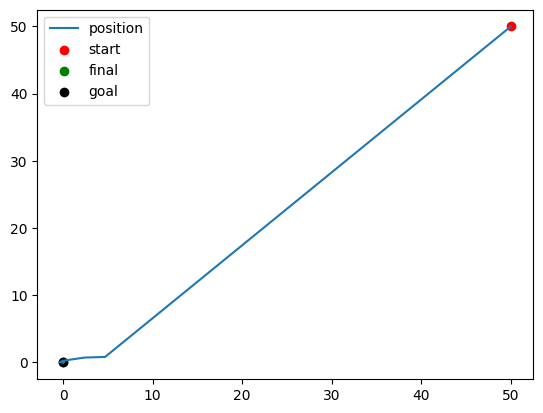

In [34]:
plt.plot(s[:, 0], s[:, 1], label='position')
plt.scatter(s[0, 0], s[0, 1], label='start', c='r')
plt.scatter(s[-1, 0], s[-1, 1], label='final', c='g')
plt.scatter(s_goal[0], s_goal[1], label='goal', c='k')
plt.legend()
plt.show()

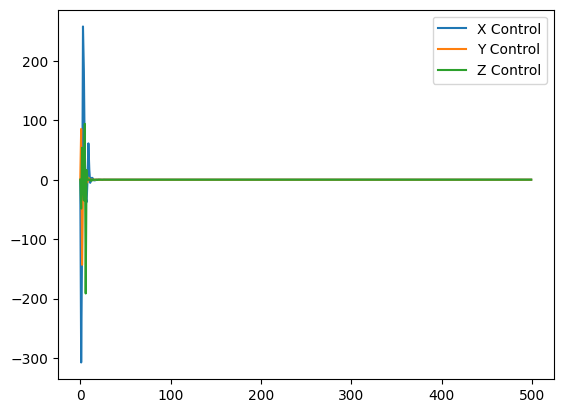

In [35]:
plt.plot(u[:, 0], label='X Control')
plt.plot(u[:, 1], label='Y Control')
plt.plot(u[:, 2], label='Z Control')
plt.legend()
plt.show()

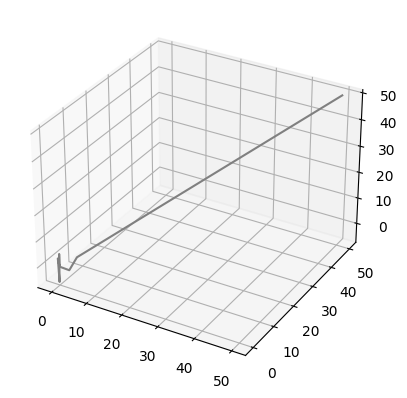

In [36]:
#3D Plot
ax = plt.axes(projection='3d')
ax.plot3D(s[:, 0], s[:, 1], s[:, 2], 'gray')

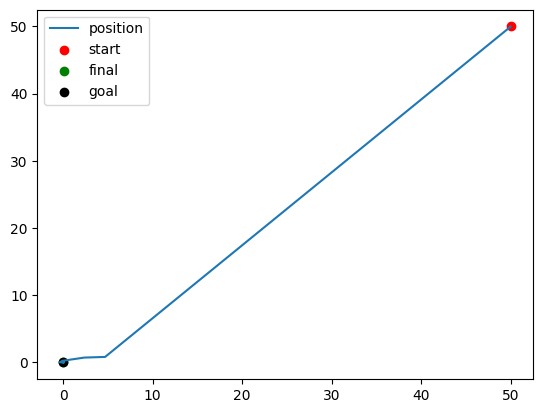

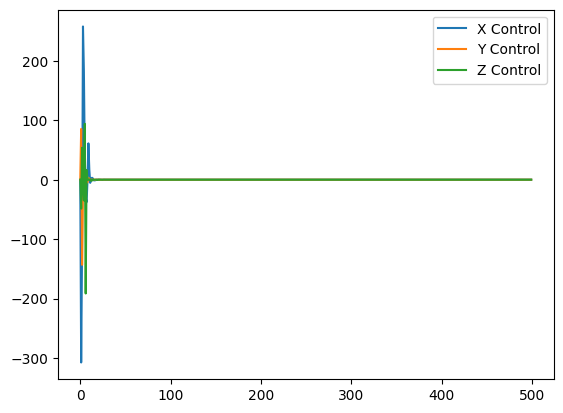

In [37]:
#Initial Guess Plot
s, u = initial_guess(s0, s_goal, N, P, Q, R, A, B)

plt.plot(s[:, 0], s[:, 1], label='position')
plt.scatter(s[0, 0], s[0, 1], label='start', c='r')
plt.scatter(s[-1, 0], s[-1, 1], label='final', c='g')
plt.scatter(s_goal[0], s_goal[1], label='goal', c='k')
plt.legend()
plt.show()

plt.plot(u[:, 0], label='X Control')
plt.plot(u[:, 1], label='Y Control')
plt.plot(u[:, 2], label='Z Control')
plt.legend()
plt.show()


In [38]:
# Plot state and control trajectories
# fig, ax = plt.subplots(1, n + m, dpi=150, figsize=(15, 2))
# plt.subplots_adjust(wspace=0.45)
# labels_s = (r'$x(t)$', r'$\theta(t)$', r'$\dot{x}(t)$', r'$\dot{\theta}(t)$')
# labels_u = (r'$u(t)$',)
# for i in range(n):
#     ax[i].plot(t, s[:, i])
#     ax[i].axhline(s_goal[i], linestyle='--', color='tab:orange')
#     ax[i].set_xlabel(r'$t$')
#     ax[i].set_ylabel(labels_s[i])
# for i in range(m):
#     ax[n + i].plot(t[:-1], u[:, i])
#     ax[n + i].axhline(u_max, linestyle='--', color='tab:orange')
#     ax[n + i].axhline(-u_max, linestyle='--', color='tab:orange')
#     ax[n + i].set_xlabel(r'$t$')
#     ax[n + i].set_ylabel(labels_u[i])
# plt.savefig('cartpole_swingup_constrained.png',
#             bbox_inches='tight')

# # Plot cost history over SCP iterations
# fig, ax = plt.subplots(1, 1, dpi=150, figsize=(8, 5))
# ax.semilogy(J)
# ax.set_xlabel(r'SCP iteration $i$')
# ax.set_ylabel(r'SCP cost $J(\bar{x}^{(i)}, \bar{u}^{(i)})$')
# plt.savefig('cartpole_swingup_constrained_cost.png',
#             bbox_inches='tight')
# plt.show()
